In [1]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [5]:
#PART 1: Load sample images and visualize
#Includes, dividing each image by its max to scale them to [0,1]
#Converting mask from float to uint8
#Changing mask pixel values (labels) from 4 to 3 (as the original labels are 0, 1, 2, 4)
#Visualize
###########################################
#View a few images

TRAIN_DATASET_PATH = "C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\"
VALIDATION_DATASET_PATH = "C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_ValidationData\\MICCAI_BraTS2020_ValidationData\\"

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355\\BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

1854.603271484375
[0 1 2 4]
[0 1 2 3]


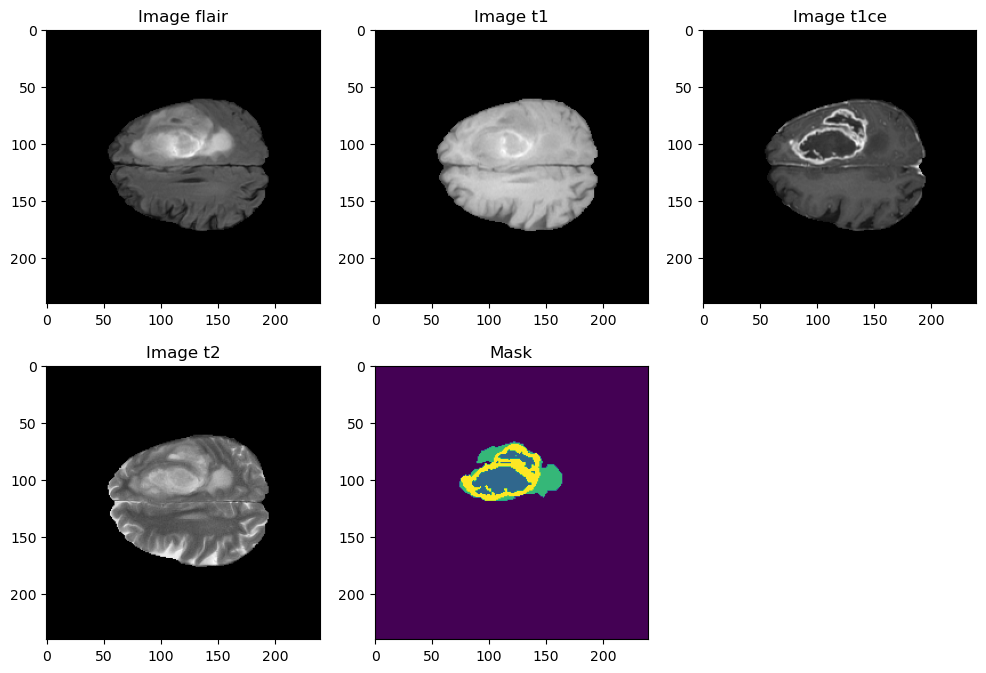

In [6]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

C:\Users\hanof\AppData\Local\Temp\ipykernel_9696\3411177873.py:33: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(test_mask[:,:,n_slice])
C:\Users\hanof\AppData\Local\Temp\ipykernel_9696\3411177873.py:33: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(test_mask[:,:,n_slice])


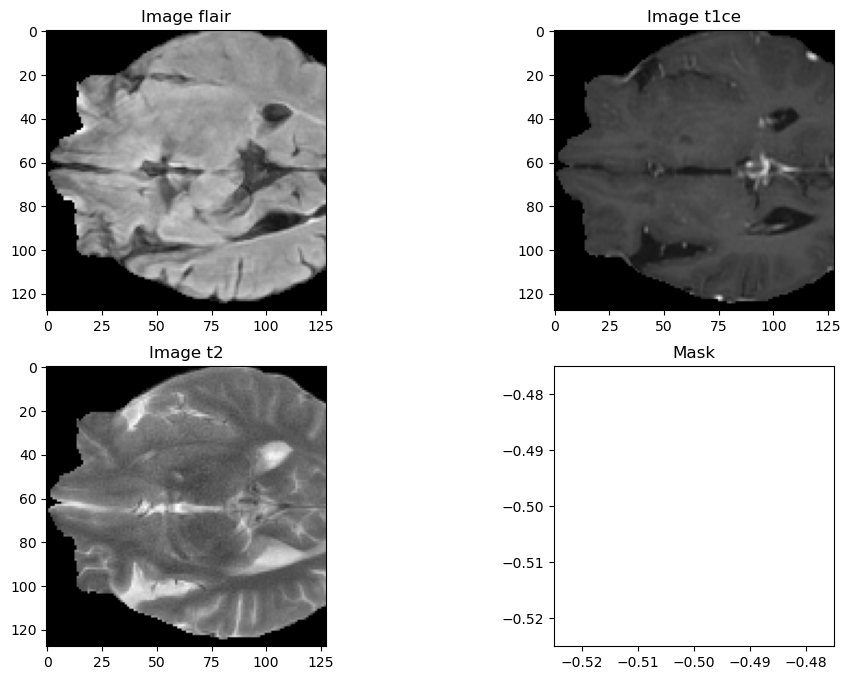

In [10]:
#PART 2: Explore the process of combining images to channels and divide them to patches
#Includes...
#Combining all 4 images to 4 channels of a numpy array.
#
################################################
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [11]:
#imsave("C:\Users\hanof\OneDrive\Desktop\Dataset\BraTS2020_TrainingData\combined255.tif", combined_x)
np.save("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\combined255.npy", combined_x)
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')

my_img=np.load("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\combined255.npy")

test_mask = to_categorical(test_mask, num_classes=4)

In [12]:
#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE

#Keras datagenerator does ntot support 3d

# # # images lists harley
#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\*\\*t2.nii"))
t1ce_list = sorted(glob.glob("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\*\\*t1ce.nii"))
flair_list = sorted(glob.glob("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\*\\*flair.nii"))
mask_list = sorted(glob.glob("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\*\\*seg.nii"))

#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes

for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_3channels\\images\\image_"+str(img)+".npy", temp_combined_images)
        np.save("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_3channels\\masks\\mask_"+str(img)+".npy", temp_mask)
        
    else:
        print("I am useless")   

Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
I am useless
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me
Now p

In [13]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [14]:
import splitfolders

input_folder = "C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_3channels\\"
output_folder = "C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_128\\"
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 688 files [01:31,  7.52 files/s]


In [15]:
from tifffile import imsave, imread
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [17]:
import numpy as np

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)
    
    # Keras needs the generator to be infinite, so we will use while True
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            # Charge les images et les masques
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            # Conversion explicite en float32 pour éviter les erreurs de type
            X = np.array(X, dtype=np.float32)
            Y = np.array(Y, dtype=np.float32)

            # Assure-toi que les images et les masques sont bien dans le bon format (float32)
            yield (X, Y)  # Renvoie les deux tableaux numpy avec batch_size échantillons

            # Incrémenter les indices pour le prochain lot
            batch_start += batch_size
            batch_end += batch_size

In [17]:
from matplotlib import pyplot as plt
import random

train_img_dir = "C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_128\\train\\images\\"
train_mask_dir = "C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_128\\train\\masks\\"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator
img, msk = train_img_datagen.__next__()

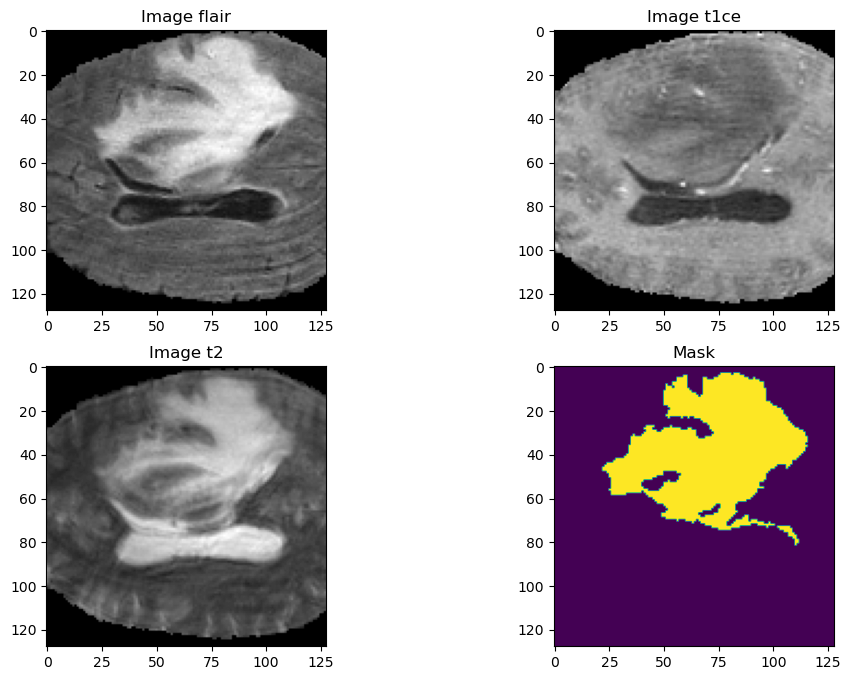

In [18]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# Training and Validation

### Building UNet Model 3D from scratch

In [3]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'

In [5]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      1,312 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ dropout_2[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv3d_6[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │    442,496 │ dropout_3[0][0]   │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 8, 8, 8,   │          0 │ conv3d_7[0][0]  

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


### training

In [7]:
import os
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

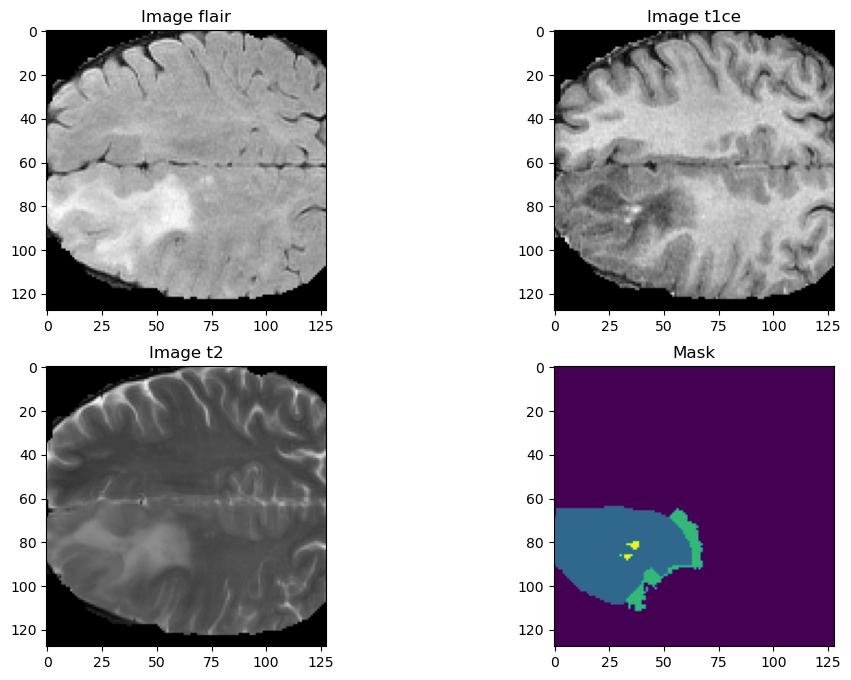

In [9]:
train_img_dir = "C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_128\\train\\images\\"
train_mask_dir = "C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_128\\train\\masks\\"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [11]:
#Define the image generators for training and validation

train_img_dir = "C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_128\\train\\images\\"
train_mask_dir = "C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_128\\train\\masks\\"

val_img_dir = "C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_128\\val\\images\\"
val_mask_dir = "C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_128\\val\\masks\\"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

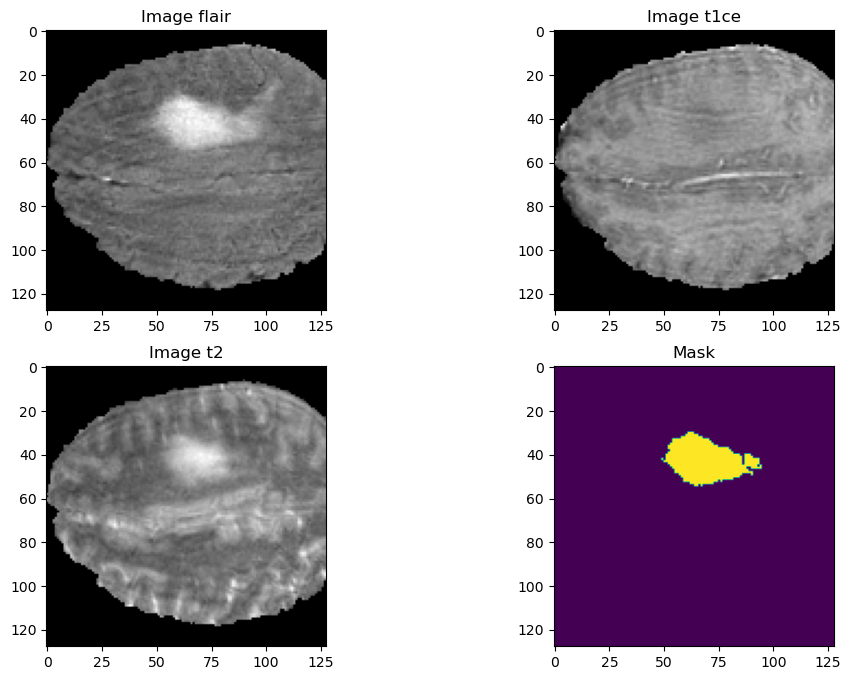

In [19]:
batch_size = 2 #A small batch size with 3 channels because we have tremendous amount of data

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [21]:
pip install segmentation_models_3D

Note: you may need to restart the kernel to use updated packages.


In [22]:
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss() #equal weights as a first attempt
focal_loss = sm.losses.CategoricalFocalLoss() 
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `keras` framework.


In [25]:
steps_per_epoch = len(train_img_list)//batch_size #The number of training images / 2
val_steps_per_epoch = len(val_img_list)//batch_size 
model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv3d_19[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 128, 128,  │      6,928 │ dropout_9[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 64, 64,    │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_4[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv3d_21[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_10[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 32, 32,    │          0 │ conv3d_22[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_5[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv3d_23[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_11[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 16, 16,    │          0 │ conv3d_24[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_6[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv3d_25[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_12[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 8, 8, 8,   │          0 │ conv3d_26[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv3d_19[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 128, 128,  │      6,928 │ dropout_9[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 64, 64,    │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_4[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv3d_21[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_10[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 32, 32,    │          0 │ conv3d_22[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_5[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv3d_23[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_11[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 16, 16,    │          0 │ conv3d_24[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_6[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv3d_25[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_12[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 8, 8, 8,   │          0 │ conv3d_26[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None


In [36]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [29]:
history = model.fit(train_img_datagen,
                    steps_per_epoch=len(train_img_list) // batch_size,
                    validation_data=val_img_datagen,
                    validation_steps=len(val_img_list) // batch_size,
                    epochs=20, verbose=1)

Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1991s 15s/step - accuracy: 0.6283 - iou_score: 0.1215 - loss: 0.8425 - val_accuracy: 0.9524 - val_iou_score: 0.2473 - val_loss: 0.7082
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2484s 19s/step - accuracy: 0.9489 - iou_score: 0.2597 - loss: 0.6923 - val_accuracy: 0.9255 - val_iou_score: 0.3026 - val_loss: 0.6574
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3489s 27s/step - accuracy: 0.9509 - iou_score: 0.3117 - loss: 0.6376 - val_accuracy: 0.9319 - val_iou_score: 0.3203 - val_loss: 0.6289
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3147s 24s/step - accuracy: 0.9431 - iou_score: 0.3201 - loss: 0.6160 - val_accuracy: 0.9369 - val_iou_score: 0.3457 - val_loss: 0.5939
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3021s 23s/step - accuracy: 0.9421 - iou_score: 0.3627 - loss: 0.5772 - val_accuracy: 0.9442 - val_iou_score: 0.3922 - val_loss: 0.5499
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2926s 23s/step - accuracy: 0.9581 - iou_score: 0.4166 - loss: 0.5144 - val_accuracy: 

In [31]:
model.save('brats_3d.hdf5')

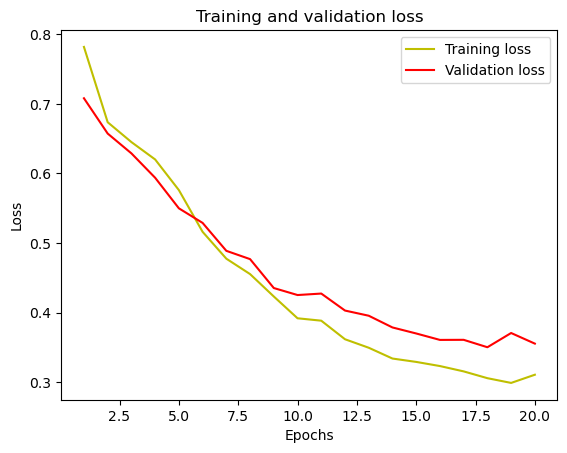

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

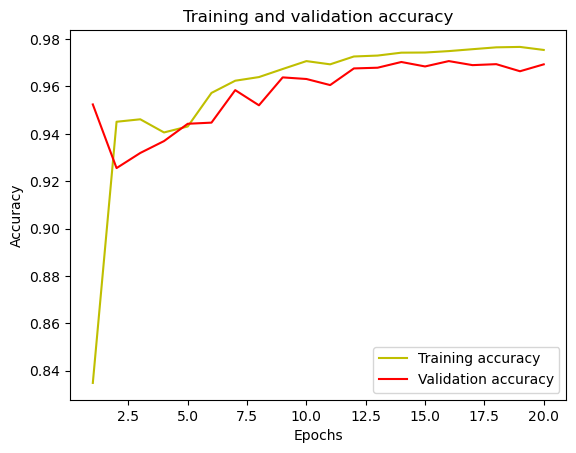

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


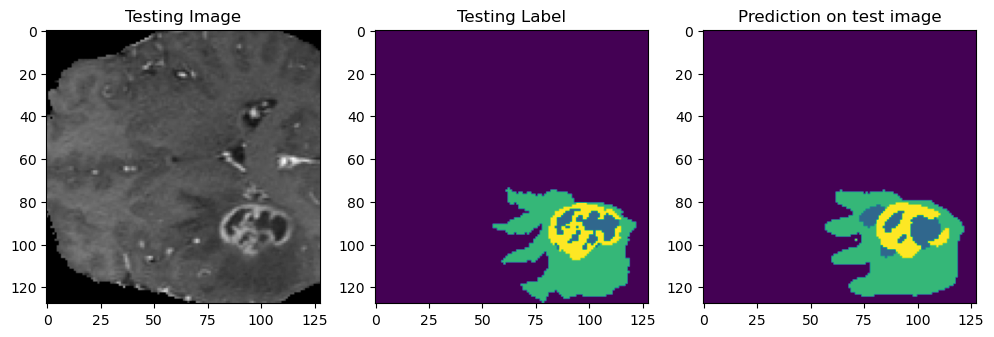

In [41]:
img_num = 82

test_img = np.load("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_128\\val\\images\\image_"+str(img_num)+".npy")

test_mask = np.load("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_TrainingData\\input_data_128\\val\\masks\\mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [1]:
from tensorflow.keras.models import load_model

In [3]:
import tensorflow as tf
print(tf.__version__)  # Vérifiez si vous utilisez TensorFlow >= 2.x

2.18.0


In [5]:
my_model = load_model('brats_3d.hdf5', compile=False)

## Appling the same preprocessing on the validation dataset

In [20]:
import glob
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [26]:
import numpy as np

In [34]:
t2_list = sorted(glob.glob("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_ValidationData\\MICCAI_BraTS2020_ValidationData\\*\\*t2.nii"))
t1ce_list = sorted(glob.glob("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_ValidationData\\MICCAI_BraTS2020_ValidationData\\*\\*t1ce.nii"))
flair_list = sorted(glob.glob("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_ValidationData\\MICCAI_BraTS2020_ValidationData\\*\\*flair.nii"))

#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes

for img in range(len(t2_list)):   #Using t2_list as all lists are of same size
    print("Now preparing image number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    np.save("C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_ValidationData\\input_data_3channels\\image_"+str(img)+".npy", temp_combined_images)        


Now preparing image and masks number:  0
Now preparing image and masks number:  1
Now preparing image and masks number:  2
Now preparing image and masks number:  3
Now preparing image and masks number:  4
Now preparing image and masks number:  5
Now preparing image and masks number:  6
Now preparing image and masks number:  7
Now preparing image and masks number:  8
Now preparing image and masks number:  9
Now preparing image and masks number:  10
Now preparing image and masks number:  11
Now preparing image and masks number:  12
Now preparing image and masks number:  13
Now preparing image and masks number:  14
Now preparing image and masks number:  15
Now preparing image and masks number:  16
Now preparing image and masks number:  17
Now preparing image and masks number:  18
Now preparing image and masks number:  19
Now preparing image and masks number:  20
Now preparing image and masks number:  21
Now preparing image and masks number:  22
Now preparing image and masks number:  23
No

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


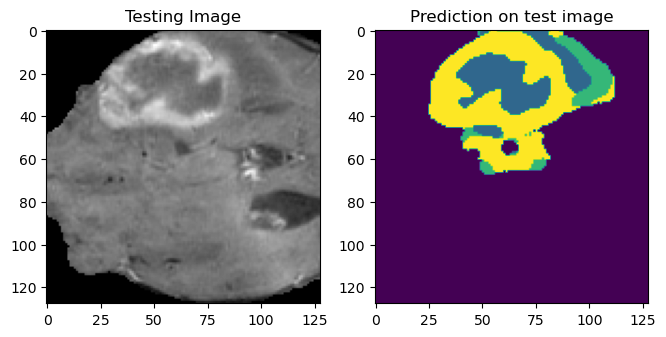

In [72]:
import numpy as np
import random
from matplotlib import pyplot as plt

# Charger un numéro d'image aléatoire dans le dataset de validation
img_num = random.randint(0, 123)  # test_img_list contient la liste des images de validation

# Charger l'image correspondant
test_img = np.load(f"C:\\Users\\hanof\\OneDrive\\Desktop\\Dataset\\BraTS2020_ValidationData\\input_data_3channels\\image_{img_num}.npy")

# Ajouter une dimension pour le modèle
test_img_input = np.expand_dims(test_img, axis=0)

# Prédiction du modèle
test_prediction = my_model.predict(test_img_input)

# Trouver l'index du masque de classe maximum dans la prédiction
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0, :, :, :]

# Sélectionner une coupe (slice) aléatoire
n_slice = random.randint(0, test_prediction_argmax.shape[2])

# Affichage des résultats
plt.figure(figsize=(12, 8))

# Image de test
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')

# Prédiction du modèle
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:,n_slice])

# Afficher les images
plt.show()